# Custom TTNet Implementation

## Setup

### Imports

In [88]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
import albumentations
import jpeg4py as jpeg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### GPU

In [89]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(0)))

# Turns on cuDNN Autotuner
torch.backends.cudnn.benchmark = True

Device: cuda:0
GPU: NVIDIA GeForce GTX TITAN X


### TTNet Params

In [97]:
# Folder paths
dataset_base_path = './Dataset/images'
savePath_base = "./Trained_Models/"
outputPath = "./Results/"

# Training parameters
train_batch = 8
val_batch = 8
test_batch = 8
num_workers = 8
learning_rate = 1e-4
eps = 1e-8
sigma = 1
#event_num = 5 # 0: Nothing, 1: Flying, 2: Bounce, 3: Racket Contact, 4: Net Contact
event_num = 4 # Fly = 0, Bounce = 1, Hit = 2, Out = 3

# Img resolutions
data_width = 1920
data_height = 1080 
TTN_width=640
TTN_height=320

seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Datset

### Configure

In [92]:
transform = albumentations.Compose([
  albumentations.Resize(height=TTN_height, width=TTN_width, interpolation=1, always_apply=True, p=1),
  albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0)
])

# TODO Rewrite this function
def smooth_event(events,event_num):
  event_idx = event_num
  is_found = False
  for i in range((len(events)+1)//2):
    middle_index =  (len(events))//2
    if((int(events[middle_index+i])==event_num or int(events[middle_index-i])==event_num) and not is_found):
      event_idx = i
      is_found = True
  n = event_idx
  prob = np.cos(n * np.pi / 8)
  if(prob<0.01):
    return 0
  else:
    return prob

class TTN_Dataset(Dataset):
  def __init__(self, split, window_size=9):
    self.window_size = window_size
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []
    self.transform = transform

    game_list = os.listdir(f"{dataset_base_path}/{split}")
    # Iterate through each game
    for game in game_list:
      game_dir = f"{dataset_base_path}/{split}/{game}"
      clips = os.listdir(game_dir)
      # Iterate through each clip
      for clip in clips:
        # Read and store annotation information
        clip_dir = f"{game_dir}/{clip}"
        annotation_path = f"{clip_dir}/Annotation.csv"
        annotation = pd.read_csv(annotation_path)
        img_paths = np.asarray(annotation.iloc[:, 0])
        ball_x = np.asarray(annotation.iloc[:, 1])
        ball_y = np.asarray(annotation.iloc[:, 2])
        event = np.asarray(annotation.iloc[:, 3])

        for frame_no, _ in enumerate(img_paths):
          # Skip indices where it is not possible to make a frame window
          if not (self.window_size-1 < frame_no <= len(img_paths)-1):
            continue

          # Get frame window image paths
          window_path = []
          middle_index = frame_no-self.window_size+(self.window_size+1)//2
          for window_frame in range(self.window_size):
            window_path.append(f"{clip_dir}/{img_paths[(frame_no+1)-self.window_size+window_frame]}")
          self.window_paths.append(window_path)

          # Downscaling ball xy coords into lower resolution
          x_downscale = ball_x[middle_index]/data_width*TTN_width
          y_downscale = ball_y[middle_index]/data_height*TTN_height
          self.xy_downscale.append([x_downscale, y_downscale])

          # Smooth events
          event_prob = torch.zeros((event_num))
          for i in range(event_num):
            event_prob[i] = smooth_event(event[frame_no+1-self.window_size:frame_no+1],i)
          self.event_probs.append(event_prob)
  
  def __getitem__(self, index):
    # Read in imgs for the window
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):
      image = jpeg.JPEG(window_path[i]).decode()
      image = transform(**{"image": image})
      image = torch.from_numpy(image['image'])
      imgs.append(image)

    window_imgs = torch.stack([img for img in imgs], dim=0)
    window_imgs = window_imgs.view(-1,window_imgs.shape[1],window_imgs.shape[2])

    # Rest of info
    # window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]
    centre_path = window_path[self.window_size//2]

    return window_imgs, xy_downscale, centre_path, self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Load Data

In [95]:
print("Loading Datasets...")
train_loader = DataLoader(TTN_Dataset(split="train"), batch_size=train_batch,shuffle=True,num_workers=num_workers,pin_memory=True,drop_last=True)
test_loader = DataLoader(TTN_Dataset(split="test"), batch_size=test_batch,shuffle=False,num_workers=num_workers,pin_memory=True)
val_loader = DataLoader(TTN_Dataset(split="val"), batch_size=val_batch,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)
print("Dataset total batches:")
print(f"Training : {len(train_loader)}")
print(f"Validation : {len(val_loader)}")
print(f"Test : {len(test_loader)}")

Loading Datasets...
Dataset total batches:
Training : 5062
Validation : 508
Test : 509


## Losses

In [9]:
# TODO This entire section probably needs a rewrite
def gaussian_1d(pos, mu, sigma):
  target = torch.exp(- (((pos - mu) / sigma) ** 2) / 2)
  return target

def ball_loss(pre_output,true_label):
  x_pred = pre_output[:, :TTN_width]
  y_pred = pre_output[:, TTN_width:]

  target_output = torch.zeros_like(pre_output)
  for i in range(pre_output.shape[0]):
    target_output_temp = torch.zeros((TTN_width+TTN_height), device=device)
    x,y = true_label[i]
    if (TTN_width > x > 0) and (TTN_height > y > 0):    
      x_axis = torch.arange(0, TTN_width, device=device)
      y_axis = torch.arange(0, TTN_height, device=device)

      target_output_temp[:TTN_width] = gaussian_1d(x_axis, x, sigma=sigma)
      target_output_temp[TTN_width:] = gaussian_1d(y_axis, y, sigma=sigma)
      target_output_temp[target_output_temp < 1e-2] = 0.
    target_output[i] = target_output_temp
    
  x_target = target_output[:, :TTN_width]
  y_target = target_output[:, TTN_width:]

  loss_x = - torch.mean(x_target * torch.log(x_pred + eps) + (1 - x_target) * torch.log(1 - x_pred + eps))
  loss_y = - torch.mean(y_target * torch.log(y_pred + eps) + (1 - y_target) * torch.log(1 - y_pred + eps))
  loss = loss_x+loss_y
  return loss

def event_loss(pre_output,true_label):
  weights = (1.0, 54.56, 38.16, 4.26)
  weights = torch.tensor(weights).to(device)
  weights = weights.view(-1,weights.shape[0])
  weights = weights / weights.sum()
  loss = -torch.mean(weights * (true_label * torch.log(pre_output + eps) + (1. - true_label) * torch.log(1 - pre_output + eps)))
  return loss


## TTNet Config

### Define Block Types

In [10]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),          
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0,ceil_mode=True),
    )
    
  def forward(self, x):
    out = self.block(x)
    return out

class ConvBlock_without_Pooling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock_without_Pooling, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )

  def forward(self, x):
    out = self.block(x)
    return out

### Define Segments

In [11]:
class BallDetection(nn.Module):
  def __init__(self, frame_window, dropout_p):
    super(BallDetection, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(in_channels = frame_window*3, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64,track_running_stats=False),
      nn.ReLU(inplace=True),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=128),
      ConvBlock(in_channels=128, out_channels=128),
      ConvBlock(in_channels=128, out_channels=256),
      ConvBlock(in_channels=256, out_channels=256)
    )
    self.FC1 = nn.Sequential(
      nn.Linear(in_features=12800, out_features=5584),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC2 = nn.Sequential(
      nn.Linear(in_features=5584, out_features=1896),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC3 = nn.Sequential(
      nn.Linear(in_features=1896, out_features=int(TTN_width+TTN_height)),
      nn.Sigmoid(),
    )
    self.dropout2d = nn.Dropout2d(p=dropout_p)

  def forward(self, x):
    block6_out = self.convBlocks(x)
    x = self.dropout2d(block6_out)
    x = x.contiguous().view(x.shape[0], -1)
    x = self.FC1(x)
    x = self.FC2(x)
    out = self.FC3(x)

    return out, block6_out

class EventSpotting(nn.Module):
  def __init__(self, dropout_p):
    super(EventSpotting, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
    )
    self.FC = nn.Sequential(           
      nn.Linear(in_features=3200, out_features=2048),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=event_num),
      nn.Sigmoid()
    )

  def forward(self, global_features, local_features):
    x = torch.cat((global_features, local_features), dim=1)
    x = self.convBlocks(x)
    x = x.contiguous().view(x.size(0), -1)
    out = self.FC(x)
    
    return out

### TTNet Model

In [12]:
class TTNet(nn.Module):
  def __init__(self, dropout_p, frame_window, threshold, tasks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    super(TTNet, self).__init__() 
    # Assign stages
    self.local_stage,self.event_spotting = None,None
    self.global_stage = BallDetection(frame_window, dropout_p)
    if "local" in tasks:
      self.local_stage = BallDetection(frame_window, dropout_p)
    if "event" in tasks:
      self.event_spotting = EventSpotting(dropout_p)

    self.threshold = threshold
    self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
    self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

  # TODO look into normalising the inputs
  def forward(self, x):
    local_out, local_in, crop_params, event_out = None, None, None, None

    global_out, global_features = self.global_stage(self.norm(x))
    if self.local_stage is not None:
      local_in, crop_params = self.crop_imgs(x, global_out)
      local_out, local_features, *_ = self.local_stage(self.norm(local_in))
      if self.event_spotting is not None:
        event_out = self.event_spotting(global_features, local_features)
    
    return global_out, local_out, local_in, crop_params, event_out

  # TODO This section needs a rewrite
  def crop_imgs(self, x, global_xy):
    global_xy_copy = global_xy.detach().clone()
    global_xy_copy[global_xy_copy < self.threshold] = 0
    crop_params = []
    ball_detected = False

    global_output = torch.zeros_like(x)
    # original size
    original_input = F.interpolate(x, (data_height, data_width))
    ####
    for i in range(x.shape[0]):
      pos_x = global_xy_copy[i, :TTN_width]
      pos_y = global_xy_copy[i, TTN_width:]

      if (torch.sum(pos_x) == 0) or (torch.sum(pos_y) == 0):
        x_center = int(TTN_width / 2)
        y_center = int(TTN_height / 2)
      else:
        x_center = torch.argmax(pos_x)
        y_center = torch.argmax(pos_y)
        ball_detected = True

      # original size
      x_center = int(x_center * (data_width/TTN_width))
      y_center = int(y_center * (data_height/TTN_height))
      x_min = max(0, x_center - int(TTN_width / 2))
      y_min = max(0, y_center - int(TTN_height / 2))
      x_max = min(data_width, x_min + TTN_width)
      y_max = min(data_height, y_min + TTN_height)
      crop_width = x_max - x_min
      crop_height = y_max - y_min
      padding_x=padding_y=0
      if (crop_height != TTN_height) or (crop_width != TTN_width):
        padding_x = int((TTN_width - crop_width) / 2)
        padding_y = int((TTN_height - crop_height) / 2)
        global_output[i, :, padding_y:(padding_y + crop_height), padding_x:(padding_x + crop_width)] = original_input[i, :,y_min:y_max, x_min: x_max]
      else:
        global_output[i, :, :, :] = original_input[i, :, y_min:y_max, x_min: x_max]
      crop_params.append([ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y])


    return global_output,crop_params

  def norm(self,x):
    if not self.mean.is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()

    return (x / 255. - self.mean) / self.std

def freeze_model(model, freeze_list):
  for layer_name, p in model.named_parameters():
    p.requires_grad = True
    for freeze_module in freeze_list:
      if freeze_module in layer_name:
        print("Freeze layer :"+freeze_module)
        p.requires_grad = False
        break
  return model

# TODO Rewrite this
def get_local_groundtruth(global_ball_pos_xyz,crop_params):
  
  local_ball_pos_xyz = []
  for i,para in enumerate(crop_params):
    ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = para
    if ball_detected:
      ori_x = global_ball_pos_xyz[0][i].item()/TTN_width*data_width
      ori_y = global_ball_pos_xyz[1][i].item()/TTN_height*data_height
      local_x = max(ori_x - x_min + padding_x, -1)
      local_y = max(ori_y - y_min + padding_y, -1)

      if not (TTN_width>local_x>=0 and TTN_height>local_y>=0):
        local_x = local_y = -1
     
    else:
      local_x = local_y = -1
    local_ball_pos_xyz.append([local_x,local_y])

  return local_ball_pos_xyz

## Traning Phase 1

In [13]:
# Training config
model_saved = False
ph1_epochs = 30
global_weight = 5
ph1_train_loss_log = []
ph1_val_loss_log = []

In [14]:
# Create model
tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 1: No model to load, start to train at epoch 0
START TO TRAIN PHASE 1: Global Stage ...
Train	 epoch: 1/30	 batch: 1000/5366	 loss: 0.32644933462142944
Train	 epoch: 1/30	 batch: 2000/5366	 loss: 0.3285984992980957
Train	 epoch: 1/30	 batch: 3000/5366	 loss: 0.3298622965812683
Train	 epoch: 1/30	 batch: 4000/5366	 loss: 0.3013961911201477
Train	 epoch: 1/30	 batch: 5000/5366	 loss: 0.23676645755767822
Train	 epoch: 1/30	 loss: 0.29320232578085687
Validation	 epoch: 1/30	 loss: 0.2700297497212887
Saving model


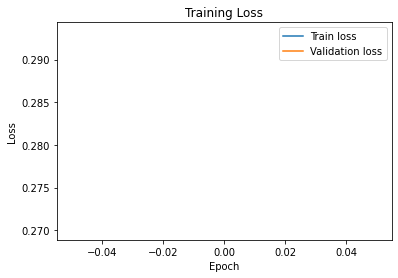

Train	 epoch: 2/30	 batch: 1000/5366	 loss: 0.32077890634536743
Train	 epoch: 2/30	 batch: 2000/5366	 loss: 0.2782900929450989
Train	 epoch: 2/30	 batch: 3000/5366	 loss: 0.21931743621826172
Train	 epoch: 2/30	 batch: 4000/5366	 loss: 0.30590081214904785
Train	 epoch: 2/30	 batch: 5000/5366	 loss: 0.25306016206741333
Train	 epoch: 2/30	 loss: 0.26730980673000254
Validation	 epoch: 2/30	 loss: 0.3743523508310318
Saving model


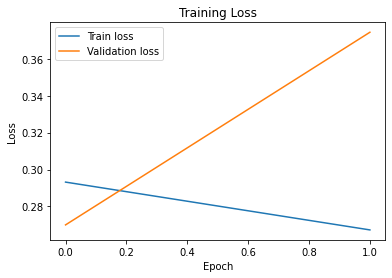

Train	 epoch: 3/30	 batch: 1000/5366	 loss: 0.2565438449382782
Train	 epoch: 3/30	 batch: 2000/5366	 loss: 0.3023903965950012
Train	 epoch: 3/30	 batch: 3000/5366	 loss: 0.2951011061668396
Train	 epoch: 3/30	 batch: 4000/5366	 loss: 0.3107747435569763
Train	 epoch: 3/30	 batch: 5000/5366	 loss: 0.23099514842033386
Train	 epoch: 3/30	 loss: 0.2548883290113718
Validation	 epoch: 3/30	 loss: 0.3454035073518753
Saving model


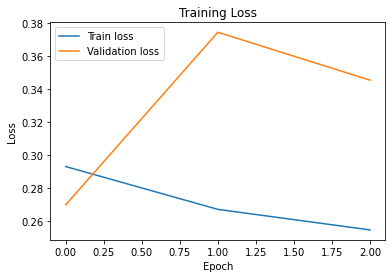

Train	 epoch: 4/30	 batch: 1000/5366	 loss: 0.26630276441574097
Train	 epoch: 4/30	 batch: 2000/5366	 loss: 0.25915613770484924
Train	 epoch: 4/30	 batch: 3000/5366	 loss: 0.29461199045181274
Train	 epoch: 4/30	 batch: 4000/5366	 loss: 0.2784278392791748
Train	 epoch: 4/30	 batch: 5000/5366	 loss: 0.29074084758758545
Train	 epoch: 4/30	 loss: 0.23814489094431482
Validation	 epoch: 4/30	 loss: 0.2930627092719078
Saving model


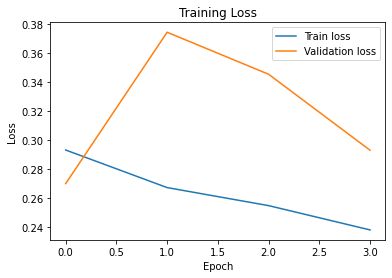

Train	 epoch: 5/30	 batch: 1000/5366	 loss: 0.2814437747001648
Train	 epoch: 5/30	 batch: 2000/5366	 loss: 0.23065146803855896
Train	 epoch: 5/30	 batch: 3000/5366	 loss: 0.30770283937454224
Train	 epoch: 5/30	 batch: 4000/5366	 loss: 0.23960694670677185
Train	 epoch: 5/30	 batch: 5000/5366	 loss: 0.19474944472312927
Train	 epoch: 5/30	 loss: 0.22190278884199766
Validation	 epoch: 5/30	 loss: 0.28663764148950577
Saving model


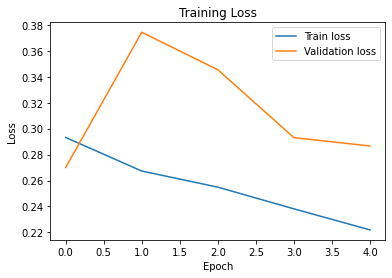

Train	 epoch: 6/30	 batch: 1000/5366	 loss: 0.18208561837673187
Train	 epoch: 6/30	 batch: 2000/5366	 loss: 0.19671045243740082
Train	 epoch: 6/30	 batch: 3000/5366	 loss: 0.27256935834884644
Train	 epoch: 6/30	 batch: 4000/5366	 loss: 0.1776207834482193
Train	 epoch: 6/30	 batch: 5000/5366	 loss: 0.19301515817642212
Train	 epoch: 6/30	 loss: 0.20876578096907128
Validation	 epoch: 6/30	 loss: 0.2595732696354389
Saving model


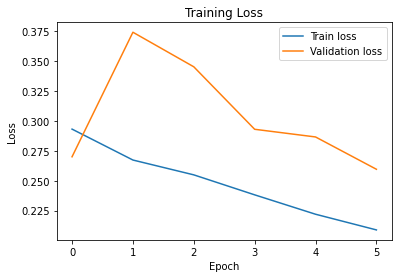

Train	 epoch: 7/30	 batch: 1000/5366	 loss: 0.2142469882965088
Train	 epoch: 7/30	 batch: 2000/5366	 loss: 0.20244714617729187
Train	 epoch: 7/30	 batch: 3000/5366	 loss: 0.1299082338809967
Train	 epoch: 7/30	 batch: 4000/5366	 loss: 0.22832438349723816
Train	 epoch: 7/30	 batch: 5000/5366	 loss: 0.15578977763652802
Train	 epoch: 7/30	 loss: 0.19813578819944216
Validation	 epoch: 7/30	 loss: 0.2577143460512161
Saving model


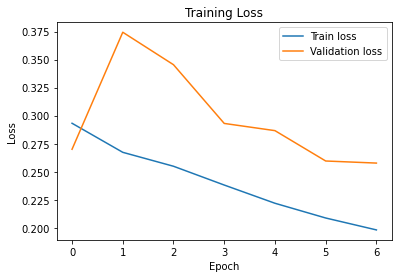

Train	 epoch: 8/30	 batch: 1000/5366	 loss: 0.17657753825187683
Train	 epoch: 8/30	 batch: 2000/5366	 loss: 0.16830021142959595
Train	 epoch: 8/30	 batch: 3000/5366	 loss: 0.14701764285564423
Train	 epoch: 8/30	 batch: 4000/5366	 loss: 0.1678086221218109
Train	 epoch: 8/30	 batch: 5000/5366	 loss: 0.25787752866744995
Train	 epoch: 8/30	 loss: 0.18890966854689617
Validation	 epoch: 8/30	 loss: 0.2581880912184715
Saving model


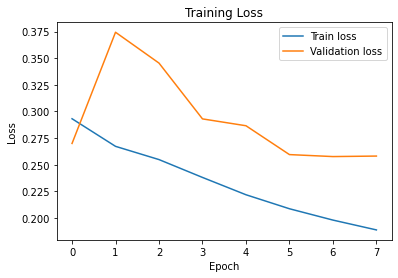

Train	 epoch: 9/30	 batch: 1000/5366	 loss: 0.1667022407054901
Train	 epoch: 9/30	 batch: 2000/5366	 loss: 0.16029831767082214
Train	 epoch: 9/30	 batch: 3000/5366	 loss: 0.19469088315963745
Train	 epoch: 9/30	 batch: 4000/5366	 loss: 0.1524229496717453
Train	 epoch: 9/30	 batch: 5000/5366	 loss: 0.20303605496883392
Train	 epoch: 9/30	 loss: 0.18036339282878425
Validation	 epoch: 9/30	 loss: 0.2614682652056217
Saving model


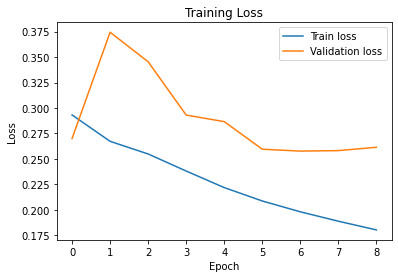

Train	 epoch: 10/30	 batch: 1000/5366	 loss: 0.20036540925502777
Train	 epoch: 10/30	 batch: 2000/5366	 loss: 0.1482972502708435
Train	 epoch: 10/30	 batch: 3000/5366	 loss: 0.12314566969871521
Train	 epoch: 10/30	 batch: 4000/5366	 loss: 0.23004692792892456
Train	 epoch: 10/30	 batch: 5000/5366	 loss: 0.13656653463840485
Train	 epoch: 10/30	 loss: 0.17302248470812892
Validation	 epoch: 10/30	 loss: 0.2605585716664791
Saving model


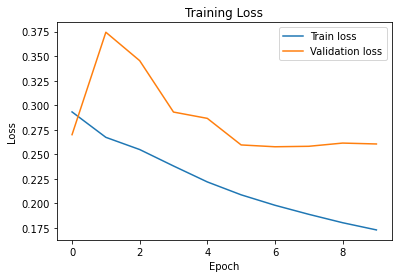

Train	 epoch: 11/30	 batch: 1000/5366	 loss: 0.15918925404548645
Train	 epoch: 11/30	 batch: 2000/5366	 loss: 0.15107575058937073
Train	 epoch: 11/30	 batch: 3000/5366	 loss: 0.19453036785125732
Train	 epoch: 11/30	 batch: 4000/5366	 loss: 0.15790505707263947
Train	 epoch: 11/30	 batch: 5000/5366	 loss: 0.11857470870018005
Train	 epoch: 11/30	 loss: 0.1665875407430804
Validation	 epoch: 11/30	 loss: 0.2679358795285225
Saving model


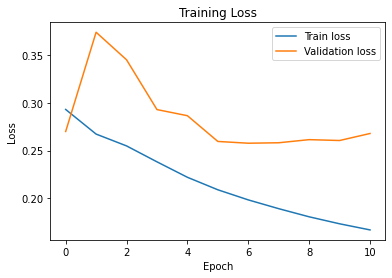

Train	 epoch: 12/30	 batch: 1000/5366	 loss: 0.14484955370426178
Train	 epoch: 12/30	 batch: 2000/5366	 loss: 0.14460331201553345
Train	 epoch: 12/30	 batch: 3000/5366	 loss: 0.12741005420684814
Train	 epoch: 12/30	 batch: 4000/5366	 loss: 0.15328142046928406
Train	 epoch: 12/30	 batch: 5000/5366	 loss: 0.15031561255455017
Train	 epoch: 12/30	 loss: 0.16096921772961625
Validation	 epoch: 12/30	 loss: 0.2646363936364651
Saving model


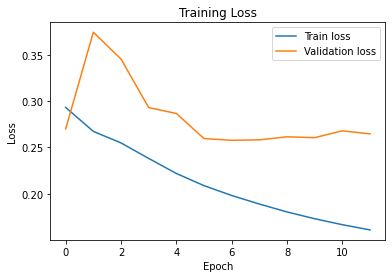

Train	 epoch: 13/30	 batch: 1000/5366	 loss: 0.1345624327659607
Train	 epoch: 13/30	 batch: 2000/5366	 loss: 0.15145421028137207
Train	 epoch: 13/30	 batch: 3000/5366	 loss: 0.17710067331790924
Train	 epoch: 13/30	 batch: 4000/5366	 loss: 0.16918039321899414
Train	 epoch: 13/30	 batch: 5000/5366	 loss: 0.11577343940734863
Train	 epoch: 13/30	 loss: 0.15606665884589266
Validation	 epoch: 13/30	 loss: 0.26081572845578194
Saving model


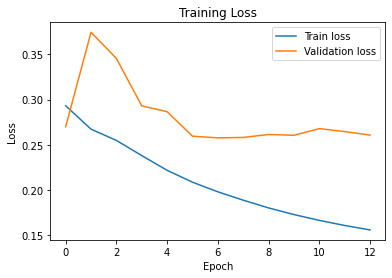

Train	 epoch: 14/30	 batch: 1000/5366	 loss: 0.09051959961652756
Train	 epoch: 14/30	 batch: 2000/5366	 loss: 0.129079207777977
Train	 epoch: 14/30	 batch: 3000/5366	 loss: 0.1133541464805603
Train	 epoch: 14/30	 batch: 4000/5366	 loss: 0.17401573061943054
Train	 epoch: 14/30	 batch: 5000/5366	 loss: 0.1858917474746704
Train	 epoch: 14/30	 loss: 0.15211596120214155
Validation	 epoch: 14/30	 loss: 0.26786496490240097
Saving model


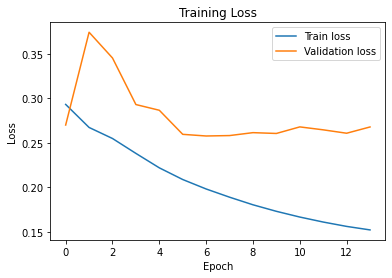

Train	 epoch: 15/30	 batch: 1000/5366	 loss: 0.1899200677871704
Train	 epoch: 15/30	 batch: 2000/5366	 loss: 0.2106940597295761
Train	 epoch: 15/30	 batch: 3000/5366	 loss: 0.15109482407569885
Train	 epoch: 15/30	 batch: 4000/5366	 loss: 0.16590365767478943
Train	 epoch: 15/30	 batch: 5000/5366	 loss: 0.11164075136184692
Train	 epoch: 15/30	 loss: 0.14800454511130495
Validation	 epoch: 15/30	 loss: 0.2678060084581375
Saving model


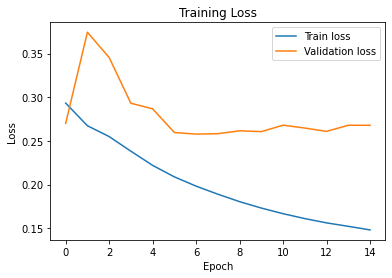

Train	 epoch: 16/30	 batch: 1000/5366	 loss: 0.11234822869300842
Train	 epoch: 16/30	 batch: 2000/5366	 loss: 0.13218797743320465
Train	 epoch: 16/30	 batch: 3000/5366	 loss: 0.13704358041286469
Train	 epoch: 16/30	 batch: 4000/5366	 loss: 0.19619673490524292
Train	 epoch: 16/30	 batch: 5000/5366	 loss: 0.13572454452514648
Train	 epoch: 16/30	 loss: 0.14475775908982846
Validation	 epoch: 16/30	 loss: 0.26674241200089455
Saving model


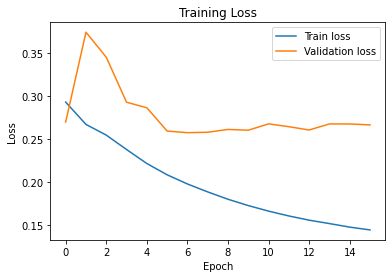

Train	 epoch: 17/30	 batch: 1000/5366	 loss: 0.15720754861831665


KeyboardInterrupt: 

In [15]:
# Train the model
if (model_saved):
  savePath = savePath_base+"Phase1/TTNet_Phase1_5.pth"
  print(f"Loading model from path: {savePath}")
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph1_train_loss_log = checkpoint['train_loss_log']
  ph1_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 1 at epoch {start_epoch} succeed")
else:
  start_epoch = 0
  print("Phase 1: No model to load, start to train at epoch 0")

print("START TO TRAIN PHASE 1: Global Stage ...")
for epoch in range(start_epoch+1, ph1_epochs + 1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    # Read in train batch
    window_imgs, xy_downscale, _, _ = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)
    
    # Calculate train (global) loss
    with autocast():
      global_out, _, _, _, _ = model(window_batch)
      train_loss = ball_loss(global_out,xy_downscale) * global_weight

    #train_loss.backward()
    #optimizer.step()
    optimizer.zero_grad()
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    
    train_loss_total += loss
    if((i+1)%1000==0):
      print(f"Train\t epoch: {epoch}/{ph1_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

  # Log training losses
  print(f"Train\t epoch: {epoch}/{ph1_epochs}\t loss: {train_loss_total/batch_num}")
  ph1_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():     
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs ,xy_downscale, _,_ = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)      
      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step and calculate val (global) loss
      with autocast():
        global_out, _, _, _, _ = model(window_batch)
        val_loss = ball_loss(global_out,xy_downscale) * global_weight
      
      loss = val_loss.detach().cpu().numpy()
      val_loss_total += loss

    # Log validation losses
    ph1_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph1_epochs}\t loss: {val_loss_total/batch_num}")
  
  print("Saving model")
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph1_train_loss_log,'val_loss_log':ph1_val_loss_log}
  savePath = savePath_base+f"/Phase1/TTNet_Phase1_{epoch}.pth"
  torch.save(state, savePath)
  model_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph1_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph1_val_loss_log,label='Validation loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph1.png")
  plt.show()

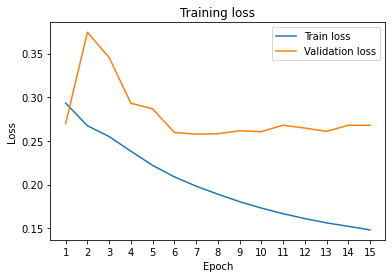

In [22]:
tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Phase1/TTNet_Phase1_15.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model']) 
ph1_train_loss_log = checkpoint['train_loss_log']
ph1_val_loss_log = checkpoint['val_loss_log']

# Plot the losses
plt.clf()
plt.plot(range(1,16),ph1_train_loss_log,label='Train loss')
plt.plot(range(1,16),ph1_val_loss_log,label='Validation loss')
plt.legend()
plt.xticks(range(1,16), range(1,16))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.savefig(outputPath+"loss_ph1.png")
plt.show()

In [23]:
def phase1_test():
  model.eval()
  batch_num = len(test_loader)
  dist = 0
  dist_x = 0
  dist_y = 0
  count = 0
  with torch.no_grad():      
    for i,data_batch in enumerate(test_loader):
      # Read in test batch
      window_imgs, xy_downscale, centre_img, _ = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)

      global_out, _, _, _, _ = model(window_batch)
      global_out_clone = global_out.clone().detach()

      for i in range(global_out.shape[0]):
        global_output_clone_x = global_out_clone[i,:TTN_width]
        global_output_clone_y = global_out_clone[i,TTN_width:TTN_width+TTN_height]
        global_output_x = torch.argmax(global_output_clone_x).item()
        global_output_y = torch.argmax(global_output_clone_y).item()

        pred_x = global_output_x*data_width/TTN_width
        pred_y = global_output_y*data_height/TTN_height

        pred_x = 0 if pred_x<0 else pred_x
        pred_y = 0 if pred_y<0 else pred_y
        pred = np.array([int(pred_x), int(pred_y)])

        ori_x = xy_downscale[0][i].item()*(data_width/TTN_width)
        ori_y = xy_downscale[1][i].item()*(data_height/TTN_height)
        ori = np.array([int(ori_x), int(ori_y)])

        dist += np.linalg.norm(ori-pred)
        dist_x += np.abs(ori_x - pred_x)
        dist_y += np.abs(ori_y - pred_y)
        count += 1
        #print(f"Distance = {np.linalg.norm(ori-pred)}")

        #ori_image = cv.imread(centre_img[i])
        #cv.circle(ori_image, (int(pred_x),int(pred_y)), 8,  (0, 0, 255), 2)

    print(f"Avg Dist = {dist/count}")
    print(f"X Dist = {dist_x/count}")
    print(f"Y Dist = {dist_y/count}")

tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Phase1/TTNet_Phase1_6.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model']) 
phase1_test()

Avg Dist = 359.3134184518572
X Dist = 315.0169656786272
Y Dist = 139.56388943057723


## Training Phase 2

In [24]:
# Training config
ph2_saved = False
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_train_loc_log = []
ph2_train_event_log = []
ph2_val_loss_log = []
ph2_val_loc_log = []
ph2_val_event_log = []

In [25]:
freeze_list = ["global_stage"]
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}

Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage


Phase 2: No model to load, start to train at epoch 0
START TO TRAIN PHASE 2: Local + Event Stage ...
+ Train	 epoch: 1/30	 batch: 1000/5366	 loss: 0.27750951051712036
+ Train	 epoch: 1/30	 batch: 2000/5366	 loss: 0.24296997487545013
+ Train	 epoch: 1/30	 batch: 3000/5366	 loss: 0.2511765956878662
+ Train	 epoch: 1/30	 batch: 4000/5366	 loss: 0.3175910711288452
+ Train	 epoch: 1/30	 batch: 5000/5366	 loss: 0.25850966572761536
Train	 epoch: 1/30	 loss: 0.2864799036203904
Validation	 epoch: 1/30	 loss: 0.27601131796836853
Saving model


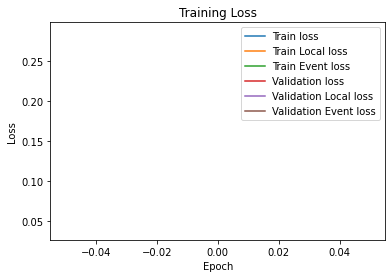

+ Train	 epoch: 2/30	 batch: 1000/5366	 loss: 0.25394681096076965
+ Train	 epoch: 2/30	 batch: 2000/5366	 loss: 0.390419602394104
+ Train	 epoch: 2/30	 batch: 3000/5366	 loss: 0.35362666845321655
+ Train	 epoch: 2/30	 batch: 4000/5366	 loss: 0.23653435707092285
+ Train	 epoch: 2/30	 batch: 5000/5366	 loss: 0.30325743556022644
Train	 epoch: 2/30	 loss: 0.2812263229657055
Validation	 epoch: 2/30	 loss: 0.31133826822042465
Saving model


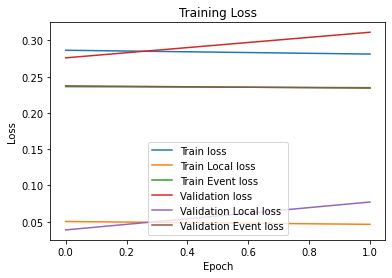

+ Train	 epoch: 3/30	 batch: 1000/5366	 loss: 0.26508527994155884
+ Train	 epoch: 3/30	 batch: 2000/5366	 loss: 0.2747535705566406
+ Train	 epoch: 3/30	 batch: 3000/5366	 loss: 0.2636908292770386
+ Train	 epoch: 3/30	 batch: 4000/5366	 loss: 0.2927064895629883
+ Train	 epoch: 3/30	 batch: 5000/5366	 loss: 0.26779651641845703
Train	 epoch: 3/30	 loss: 0.27970109371509383
Validation	 epoch: 3/30	 loss: 0.30690404027700424
Saving model


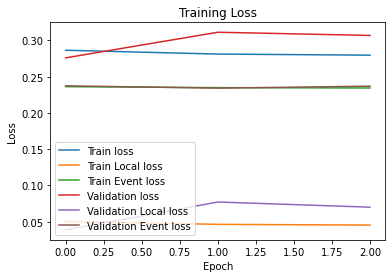

+ Train	 epoch: 4/30	 batch: 1000/5366	 loss: 0.3720223605632782
+ Train	 epoch: 4/30	 batch: 2000/5366	 loss: 0.32727789878845215
+ Train	 epoch: 4/30	 batch: 3000/5366	 loss: 0.30940383672714233
+ Train	 epoch: 4/30	 batch: 4000/5366	 loss: 0.2642914056777954
+ Train	 epoch: 4/30	 batch: 5000/5366	 loss: 0.26717907190322876
Train	 epoch: 4/30	 loss: 0.27822044763076764
Validation	 epoch: 4/30	 loss: 0.2799912467598915
Saving model


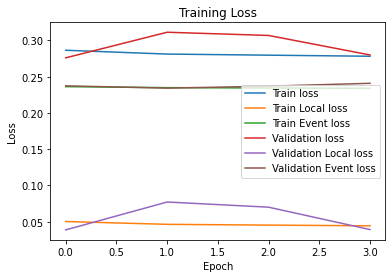

+ Train	 epoch: 5/30	 batch: 1000/5366	 loss: 0.34121930599212646
+ Train	 epoch: 5/30	 batch: 2000/5366	 loss: 0.27311208844184875
+ Train	 epoch: 5/30	 batch: 3000/5366	 loss: 0.25133347511291504
+ Train	 epoch: 5/30	 batch: 4000/5366	 loss: 0.2585608661174774
+ Train	 epoch: 5/30	 batch: 5000/5366	 loss: 0.2689548432826996
Train	 epoch: 5/30	 loss: 0.27616166433668654
Validation	 epoch: 5/30	 loss: 0.2718084007501602
Saving model


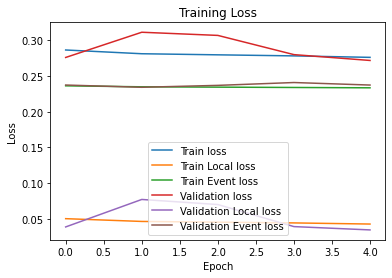

+ Train	 epoch: 6/30	 batch: 1000/5366	 loss: 0.2419230192899704
+ Train	 epoch: 6/30	 batch: 2000/5366	 loss: 0.34561479091644287
+ Train	 epoch: 6/30	 batch: 3000/5366	 loss: 0.30137041211128235
+ Train	 epoch: 6/30	 batch: 4000/5366	 loss: 0.2532205581665039
+ Train	 epoch: 6/30	 batch: 5000/5366	 loss: 0.27935484051704407
Train	 epoch: 6/30	 loss: 0.2739967145706085
Validation	 epoch: 6/30	 loss: 0.27363231033086777
Saving model


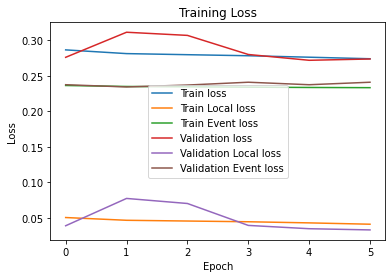

+ Train	 epoch: 7/30	 batch: 1000/5366	 loss: 0.2705620527267456
+ Train	 epoch: 7/30	 batch: 2000/5366	 loss: 0.2807542383670807
+ Train	 epoch: 7/30	 batch: 3000/5366	 loss: 0.34403759241104126
+ Train	 epoch: 7/30	 batch: 4000/5366	 loss: 0.35328614711761475
+ Train	 epoch: 7/30	 batch: 5000/5366	 loss: 0.28929218649864197
Train	 epoch: 7/30	 loss: 0.27255857410135
Validation	 epoch: 7/30	 loss: 0.2679344527423382
Saving model


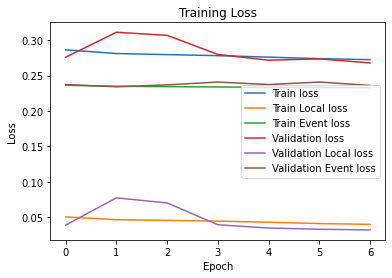

+ Train	 epoch: 8/30	 batch: 1000/5366	 loss: 0.2608615756034851
+ Train	 epoch: 8/30	 batch: 2000/5366	 loss: 0.30877256393432617
+ Train	 epoch: 8/30	 batch: 3000/5366	 loss: 0.30138513445854187
+ Train	 epoch: 8/30	 batch: 4000/5366	 loss: 0.2420087605714798
+ Train	 epoch: 8/30	 batch: 5000/5366	 loss: 0.2630647122859955
Train	 epoch: 8/30	 loss: 0.2715497237341732
Validation	 epoch: 8/30	 loss: 0.2670796513557434
Saving model


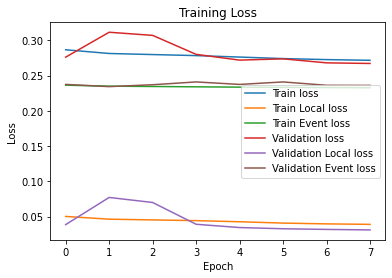

+ Train	 epoch: 9/30	 batch: 1000/5366	 loss: 0.24650458991527557
+ Train	 epoch: 9/30	 batch: 2000/5366	 loss: 0.2606279253959656
+ Train	 epoch: 9/30	 batch: 3000/5366	 loss: 0.23517194390296936
+ Train	 epoch: 9/30	 batch: 4000/5366	 loss: 0.243554949760437
+ Train	 epoch: 9/30	 batch: 5000/5366	 loss: 0.23134374618530273
Train	 epoch: 9/30	 loss: 0.27067160331743045
Validation	 epoch: 9/30	 loss: 0.26642757281661034
Saving model


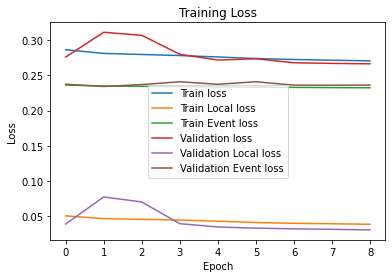

+ Train	 epoch: 10/30	 batch: 1000/5366	 loss: 0.24816545844078064
+ Train	 epoch: 10/30	 batch: 2000/5366	 loss: 0.24968363344669342
+ Train	 epoch: 10/30	 batch: 3000/5366	 loss: 0.307844340801239
+ Train	 epoch: 10/30	 batch: 4000/5366	 loss: 0.2968156635761261
+ Train	 epoch: 10/30	 batch: 5000/5366	 loss: 0.249583438038826
Train	 epoch: 10/30	 loss: 0.2698553286512263
Validation	 epoch: 10/30	 loss: 0.2680956795811653
Saving model


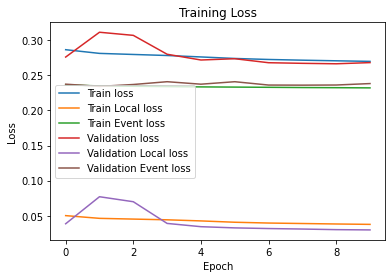

+ Train	 epoch: 11/30	 batch: 1000/5366	 loss: 0.3423764109611511
+ Train	 epoch: 11/30	 batch: 2000/5366	 loss: 0.3150986433029175
+ Train	 epoch: 11/30	 batch: 3000/5366	 loss: 0.29768604040145874
+ Train	 epoch: 11/30	 batch: 4000/5366	 loss: 0.2797209620475769
+ Train	 epoch: 11/30	 batch: 5000/5366	 loss: 0.24152354896068573
Train	 epoch: 11/30	 loss: 0.2693635644783425
Validation	 epoch: 11/30	 loss: 0.26629143208265305
Saving model


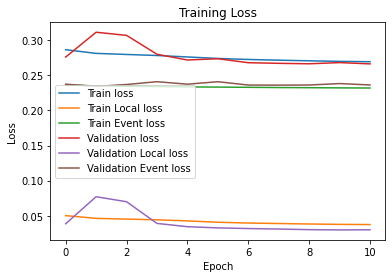

+ Train	 epoch: 12/30	 batch: 1000/5366	 loss: 0.3256518840789795
+ Train	 epoch: 12/30	 batch: 2000/5366	 loss: 0.2597932517528534
+ Train	 epoch: 12/30	 batch: 3000/5366	 loss: 0.238423153758049
+ Train	 epoch: 12/30	 batch: 4000/5366	 loss: 0.2561172544956207
+ Train	 epoch: 12/30	 batch: 5000/5366	 loss: 0.24476541578769684
Train	 epoch: 12/30	 loss: 0.2687365187306347
Validation	 epoch: 12/30	 loss: 0.26563097909092903
Saving model


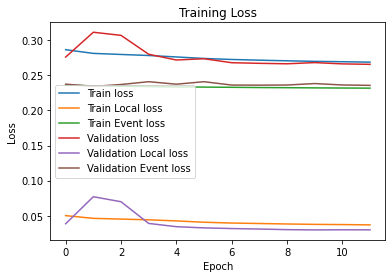

+ Train	 epoch: 13/30	 batch: 1000/5366	 loss: 0.38375186920166016
+ Train	 epoch: 13/30	 batch: 2000/5366	 loss: 0.23025868833065033
+ Train	 epoch: 13/30	 batch: 3000/5366	 loss: 0.25979405641555786
+ Train	 epoch: 13/30	 batch: 4000/5366	 loss: 0.2534111440181732
+ Train	 epoch: 13/30	 batch: 5000/5366	 loss: 0.24949142336845398
Train	 epoch: 13/30	 loss: 0.2683254520683381
Validation	 epoch: 13/30	 loss: 0.268113411962986
Saving model


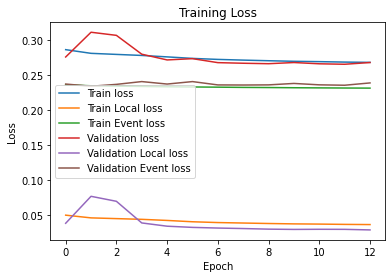

+ Train	 epoch: 14/30	 batch: 1000/5366	 loss: 0.2726779580116272
+ Train	 epoch: 14/30	 batch: 2000/5366	 loss: 0.24163278937339783
+ Train	 epoch: 14/30	 batch: 3000/5366	 loss: 0.26921090483665466
+ Train	 epoch: 14/30	 batch: 4000/5366	 loss: 0.2696235775947571
+ Train	 epoch: 14/30	 batch: 5000/5366	 loss: 0.24476878345012665
Train	 epoch: 14/30	 loss: 0.26784246605399203
Validation	 epoch: 14/30	 loss: 0.2658776715397835
Saving model


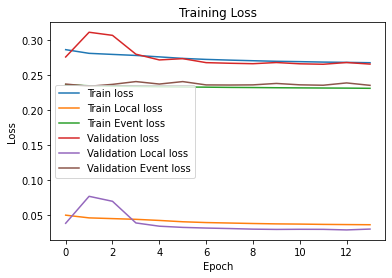

+ Train	 epoch: 15/30	 batch: 1000/5366	 loss: 0.23072803020477295
+ Train	 epoch: 15/30	 batch: 2000/5366	 loss: 0.2492128163576126
+ Train	 epoch: 15/30	 batch: 3000/5366	 loss: 0.2570398449897766
+ Train	 epoch: 15/30	 batch: 4000/5366	 loss: 0.2566770613193512
+ Train	 epoch: 15/30	 batch: 5000/5366	 loss: 0.27501997351646423
Train	 epoch: 15/30	 loss: 0.26749047574504203
Validation	 epoch: 15/30	 loss: 0.26777929812669754
Saving model


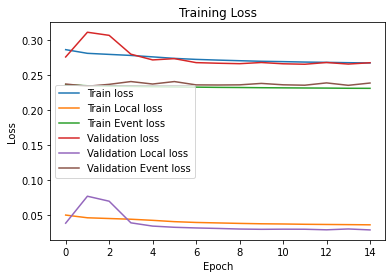

+ Train	 epoch: 16/30	 batch: 1000/5366	 loss: 0.3257920742034912
+ Train	 epoch: 16/30	 batch: 2000/5366	 loss: 0.30661648511886597
+ Train	 epoch: 16/30	 batch: 3000/5366	 loss: 0.25127869844436646
+ Train	 epoch: 16/30	 batch: 4000/5366	 loss: 0.27778375148773193
+ Train	 epoch: 16/30	 batch: 5000/5366	 loss: 0.30808597803115845
Train	 epoch: 16/30	 loss: 0.26702118593334395
Validation	 epoch: 16/30	 loss: 0.26544204726815224
Saving model


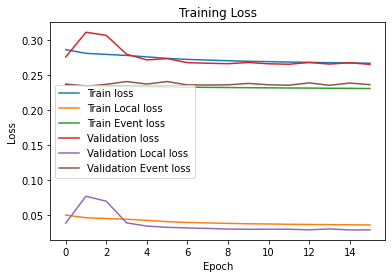

+ Train	 epoch: 17/30	 batch: 1000/5366	 loss: 0.2859722077846527
+ Train	 epoch: 17/30	 batch: 2000/5366	 loss: 0.26133257150650024
+ Train	 epoch: 17/30	 batch: 3000/5366	 loss: 0.29884040355682373
+ Train	 epoch: 17/30	 batch: 4000/5366	 loss: 0.2450534701347351
+ Train	 epoch: 17/30	 batch: 5000/5366	 loss: 0.26437532901763916
Train	 epoch: 17/30	 loss: 0.2666712744863363
Validation	 epoch: 17/30	 loss: 0.2676542438566685
Saving model


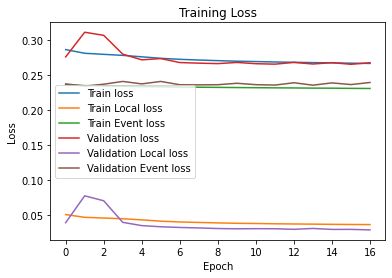

+ Train	 epoch: 18/30	 batch: 1000/5366	 loss: 0.2328011393547058
+ Train	 epoch: 18/30	 batch: 2000/5366	 loss: 0.24562767148017883
+ Train	 epoch: 18/30	 batch: 3000/5366	 loss: 0.26648497581481934
+ Train	 epoch: 18/30	 batch: 4000/5366	 loss: 0.2583796977996826
+ Train	 epoch: 18/30	 batch: 5000/5366	 loss: 0.2896811366081238
Train	 epoch: 18/30	 loss: 0.2665005619490142
Validation	 epoch: 18/30	 loss: 0.26904986053705215
Saving model


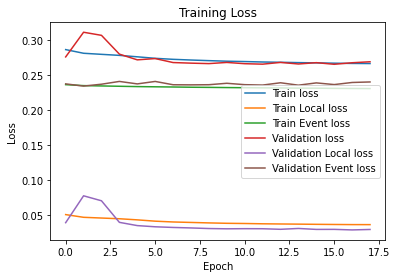

+ Train	 epoch: 19/30	 batch: 1000/5366	 loss: 0.3316507935523987
+ Train	 epoch: 19/30	 batch: 2000/5366	 loss: 0.2635796070098877
+ Train	 epoch: 19/30	 batch: 3000/5366	 loss: 0.25555098056793213
+ Train	 epoch: 19/30	 batch: 4000/5366	 loss: 0.3072708249092102
+ Train	 epoch: 19/30	 batch: 5000/5366	 loss: 0.30323290824890137
Train	 epoch: 19/30	 loss: 0.266212899416985
Validation	 epoch: 19/30	 loss: 0.2679688446223736
Saving model


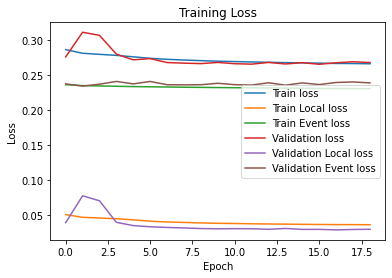

+ Train	 epoch: 20/30	 batch: 1000/5366	 loss: 0.24869869649410248
+ Train	 epoch: 20/30	 batch: 2000/5366	 loss: 0.24086225032806396
+ Train	 epoch: 20/30	 batch: 3000/5366	 loss: 0.26281940937042236
+ Train	 epoch: 20/30	 batch: 4000/5366	 loss: 0.2451012283563614
+ Train	 epoch: 20/30	 batch: 5000/5366	 loss: 0.2572037875652313
Train	 epoch: 20/30	 loss: 0.26595034339769624
Validation	 epoch: 20/30	 loss: 0.26772234961390495
Saving model


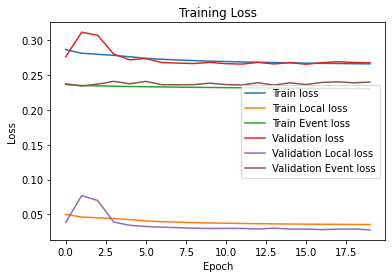

+ Train	 epoch: 21/30	 batch: 1000/5366	 loss: 0.2645421624183655
+ Train	 epoch: 21/30	 batch: 2000/5366	 loss: 0.26002049446105957
+ Train	 epoch: 21/30	 batch: 3000/5366	 loss: 0.2244480699300766
+ Train	 epoch: 21/30	 batch: 4000/5366	 loss: 0.29158803820610046
+ Train	 epoch: 21/30	 batch: 5000/5366	 loss: 0.255106121301651
Train	 epoch: 21/30	 loss: 0.26582970287466157
Validation	 epoch: 21/30	 loss: 0.26627201586961746
Saving model


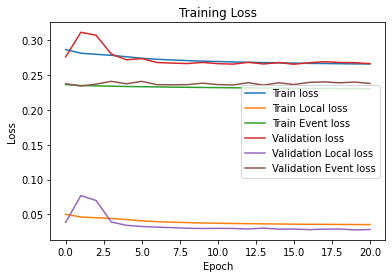

+ Train	 epoch: 22/30	 batch: 1000/5366	 loss: 0.2597445845603943
+ Train	 epoch: 22/30	 batch: 2000/5366	 loss: 0.24293988943099976
+ Train	 epoch: 22/30	 batch: 3000/5366	 loss: 0.2671080231666565
+ Train	 epoch: 22/30	 batch: 4000/5366	 loss: 0.2502361238002777
+ Train	 epoch: 22/30	 batch: 5000/5366	 loss: 0.24834099411964417
Train	 epoch: 22/30	 loss: 0.2652389106635411
Validation	 epoch: 22/30	 loss: 0.2676885239779949
Saving model


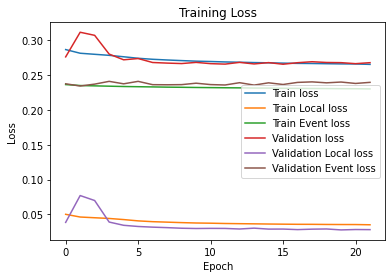

+ Train	 epoch: 23/30	 batch: 1000/5366	 loss: 0.24482077360153198
+ Train	 epoch: 23/30	 batch: 2000/5366	 loss: 0.2625463902950287
+ Train	 epoch: 23/30	 batch: 3000/5366	 loss: 0.2436494529247284
+ Train	 epoch: 23/30	 batch: 4000/5366	 loss: 0.2493259608745575
+ Train	 epoch: 23/30	 batch: 5000/5366	 loss: 0.30949997901916504
Train	 epoch: 23/30	 loss: 0.264909068892418
Validation	 epoch: 23/30	 loss: 0.2702411450445652
Saving model


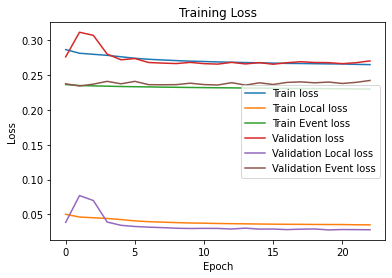

+ Train	 epoch: 24/30	 batch: 1000/5366	 loss: 0.2488509714603424
+ Train	 epoch: 24/30	 batch: 2000/5366	 loss: 0.2465648502111435
+ Train	 epoch: 24/30	 batch: 3000/5366	 loss: 0.24163615703582764
+ Train	 epoch: 24/30	 batch: 4000/5366	 loss: 0.2754308581352234
+ Train	 epoch: 24/30	 batch: 5000/5366	 loss: 0.24498561024665833
Train	 epoch: 24/30	 loss: 0.2648872902566179
Validation	 epoch: 24/30	 loss: 0.2679278887808323
Saving model


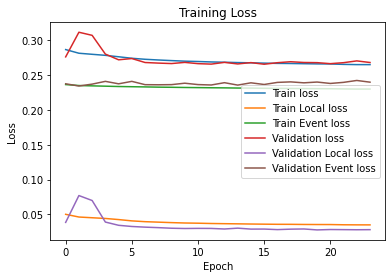

+ Train	 epoch: 25/30	 batch: 1000/5366	 loss: 0.2389959990978241
+ Train	 epoch: 25/30	 batch: 2000/5366	 loss: 0.2674557566642761
+ Train	 epoch: 25/30	 batch: 3000/5366	 loss: 0.23227331042289734
+ Train	 epoch: 25/30	 batch: 4000/5366	 loss: 0.3139415979385376
+ Train	 epoch: 25/30	 batch: 5000/5366	 loss: 0.2742428779602051
Train	 epoch: 25/30	 loss: 0.26485641905222196
Validation	 epoch: 25/30	 loss: 0.26549389213323593
Saving model


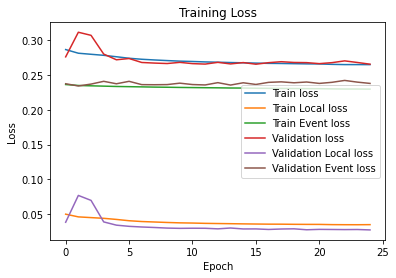

+ Train	 epoch: 26/30	 batch: 1000/5366	 loss: 0.3036760687828064
+ Train	 epoch: 26/30	 batch: 2000/5366	 loss: 0.29070237278938293
+ Train	 epoch: 26/30	 batch: 3000/5366	 loss: 0.24504591524600983
+ Train	 epoch: 26/30	 batch: 4000/5366	 loss: 0.2876163125038147


KeyboardInterrupt: 

In [26]:
if ph2_saved:
  savePath = savePath_base+"TTNet_Phase2_1.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph2_train_loss_log = checkpoint['train_loss_log']
  ph2_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 2 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase1/TTNet_Phase1_6.pth", map_location='cpu')
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  pretrained_dict = load_weights_local_stage(pretrained_dict)
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict, strict=False)
  model = model.to(device)

  start_epoch = 0
  print("Phase 2: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 2: Local + Event Stage ...')
for epoch in range(start_epoch+1, ph2_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0
  tr_loc_loss_total = 0
  tr_event_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

    # Model forward step
    with autocast():
      _, local_out, _, crop_params, event_out = model(window_batch)

    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (local+event) loss
    with autocast():
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = local_loss_train + event_loss_train
    
    optimizer.zero_grad()
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    loc = local_loss_train.detach().cpu().numpy()
    event = event_loss_train.detach().cpu().numpy()
    
    train_loss_total += loss
    tr_loc_loss_total += loc
    tr_event_loss_total += event

    if((i+1)%1000==0):
      print(f"+ Train\t epoch: {epoch}/{ph2_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainimg losses
  print(f"Train\t epoch: {epoch}/{ph2_epochs}\t loss: {train_loss_total/batch_num}")
  ph2_train_loss_log.append(train_loss_total/batch_num)
  ph2_train_loc_log.append(tr_loc_loss_total/batch_num)
  ph2_train_event_log.append(tr_event_loss_total/batch_num)

  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    val_loc_loss_total = 0
    val_event_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      with autocast():
        _, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (local+event) loss
      with autocast():
        local_loss_val = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_val = event_loss(event_out,event_probs) * event_weight
        val_loss = local_loss_val + event_loss_val

      loss = val_loss.detach().cpu().numpy()
      loc = local_loss_val.detach().cpu().numpy()
      event = event_loss_val.detach().cpu().numpy()
      print(f"{val_loss}, {event+loc}")


      val_loss_total += loss
      val_loc_loss_total += loc
      val_event_loss_total += event
      #val_loss_total += val_loss.item()

    ph2_val_loss_log.append(val_loss_total/batch_num)
    ph2_val_loc_log.append(val_loc_loss_total/batch_num)
    ph2_val_event_log.append(val_event_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph2_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"Phase2/TTNet_Phase2_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph2_train_loss_log,'val_loss_log':ph2_val_loss_log}
  torch.save(state, savePath) 
  ph2_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph2_train_loc_log,label='Train Local loss')
  plt.plot(range(epoch),ph2_train_event_log,label='Train Event loss')
  plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
  plt.plot(range(epoch),ph2_val_loc_log,label='Validation Local loss')
  plt.plot(range(epoch),ph2_val_event_log,label='Validation Event loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph2.png")
  plt.show()

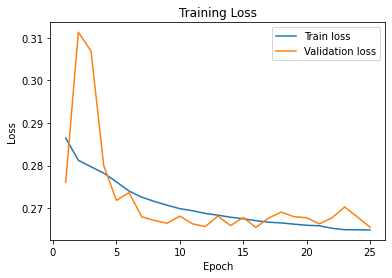

In [29]:
# Plot the losses
plt.clf()
plt.plot(range(1, 26),ph2_train_loss_log,label='Train loss')
plt.plot(range(1, 26),ph2_val_loss_log,label='Validation loss')
plt.legend()
#plt.xticks(range(epoch), range(1,31))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(outputPath+"loss_ph2.png")
plt.show()

## Training Phase 3

In [ ]:
# Training config
ph3_saved = False
ph3_epochs = 20
global_weight = 1
local_weight = 1
event_weight = 1
ph3_train_loss_log = []
ph3_val_loss_log = []

In [ ]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 3: No model to load, start to train at epoch 0
START TO TRAIN PHASE 3: All Stages ...
+ Train	 epoch: 1/20	 batch: 500/5366	 loss: 0.11248151957988739
+ Train	 epoch: 1/20	 batch: 1000/5366	 loss: 0.12964323163032532
+ Train	 epoch: 1/20	 batch: 1500/5366	 loss: 0.11606688052415848
+ Train	 epoch: 1/20	 batch: 2000/5366	 loss: 0.12197147309780121
+ Train	 epoch: 1/20	 batch: 2500/5366	 loss: 0.11734142154455185
+ Train	 epoch: 1/20	 batch: 3000/5366	 loss: 0.09346546232700348
+ Train	 epoch: 1/20	 batch: 3500/5366	 loss: 0.10655844211578369
+ Train	 epoch: 1/20	 batch: 4000/5366	 loss: 0.14281190931797028
+ Train	 epoch: 1/20	 batch: 4500/5366	 loss: 0.12687410414218903
+ Train	 epoch: 1/20	 batch: 5000/5366	 loss: 0.10927312821149826
Train	 epoch: 1/20	 loss: 0.11794004383268883
Validation	 epoch: 1/20	 loss: 0.14946246519684792
Saving model


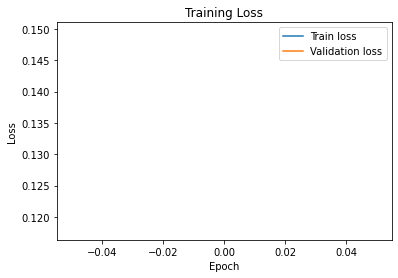

+ Train	 epoch: 2/20	 batch: 500/5366	 loss: 0.11367252469062805
+ Train	 epoch: 2/20	 batch: 1000/5366	 loss: 0.10235273092985153
+ Train	 epoch: 2/20	 batch: 1500/5366	 loss: 0.13091020286083221
+ Train	 epoch: 2/20	 batch: 2000/5366	 loss: 0.10448405146598816
+ Train	 epoch: 2/20	 batch: 2500/5366	 loss: 0.11656750738620758
+ Train	 epoch: 2/20	 batch: 3000/5366	 loss: 0.13290917873382568
+ Train	 epoch: 2/20	 batch: 3500/5366	 loss: 0.13468042016029358
+ Train	 epoch: 2/20	 batch: 4000/5366	 loss: 0.1379258930683136
+ Train	 epoch: 2/20	 batch: 4500/5366	 loss: 0.14734211564064026
+ Train	 epoch: 2/20	 batch: 5000/5366	 loss: 0.0945959985256195
Train	 epoch: 2/20	 loss: 0.11727698259347195
Validation	 epoch: 2/20	 loss: 0.1452317051589489
Saving model


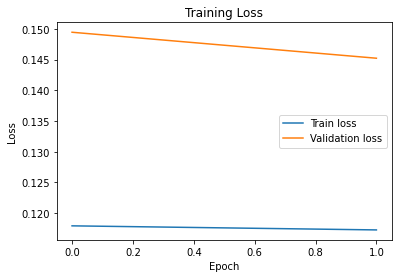

+ Train	 epoch: 3/20	 batch: 500/5366	 loss: 0.1013563796877861
+ Train	 epoch: 3/20	 batch: 1000/5366	 loss: 0.12800133228302002
+ Train	 epoch: 3/20	 batch: 1500/5366	 loss: 0.12465781718492508
+ Train	 epoch: 3/20	 batch: 2000/5366	 loss: 0.11221922934055328
+ Train	 epoch: 3/20	 batch: 2500/5366	 loss: 0.09984563291072845
+ Train	 epoch: 3/20	 batch: 3000/5366	 loss: 0.10953666269779205
+ Train	 epoch: 3/20	 batch: 3500/5366	 loss: 0.1265457272529602
+ Train	 epoch: 3/20	 batch: 4000/5366	 loss: 0.1159297376871109
+ Train	 epoch: 3/20	 batch: 4500/5366	 loss: 0.13383668661117554
+ Train	 epoch: 3/20	 batch: 5000/5366	 loss: 0.0994986966252327
Train	 epoch: 3/20	 loss: 0.11703908361114097
Validation	 epoch: 3/20	 loss: 0.15032823756337166
Saving model


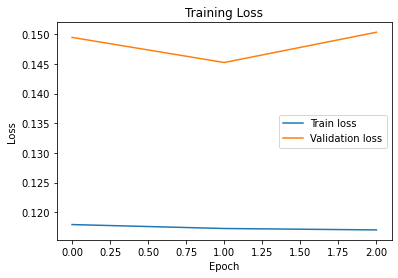

+ Train	 epoch: 4/20	 batch: 500/5366	 loss: 0.10854285955429077
+ Train	 epoch: 4/20	 batch: 1000/5366	 loss: 0.11072205007076263
+ Train	 epoch: 4/20	 batch: 1500/5366	 loss: 0.1212582141160965
+ Train	 epoch: 4/20	 batch: 2000/5366	 loss: 0.11260239034891129
+ Train	 epoch: 4/20	 batch: 2500/5366	 loss: 0.1069657951593399
+ Train	 epoch: 4/20	 batch: 3000/5366	 loss: 0.11185348033905029
+ Train	 epoch: 4/20	 batch: 3500/5366	 loss: 0.11814205348491669
+ Train	 epoch: 4/20	 batch: 4000/5366	 loss: 0.12700241804122925
+ Train	 epoch: 4/20	 batch: 4500/5366	 loss: 0.08791395276784897
+ Train	 epoch: 4/20	 batch: 5000/5366	 loss: 0.11829447746276855
Train	 epoch: 4/20	 loss: 0.11630718321291271
Validation	 epoch: 4/20	 loss: 0.14368680864572525
Saving model


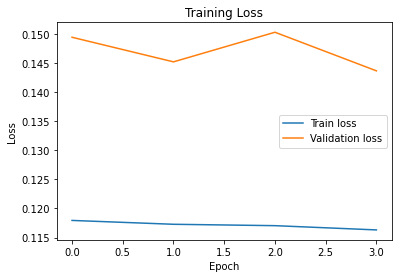

+ Train	 epoch: 5/20	 batch: 500/5366	 loss: 0.10028044879436493
+ Train	 epoch: 5/20	 batch: 1000/5366	 loss: 0.11223728954792023
+ Train	 epoch: 5/20	 batch: 1500/5366	 loss: 0.11323092877864838
+ Train	 epoch: 5/20	 batch: 2000/5366	 loss: 0.11068890988826752
+ Train	 epoch: 5/20	 batch: 2500/5366	 loss: 0.10671566426753998
+ Train	 epoch: 5/20	 batch: 3000/5366	 loss: 0.144054114818573
+ Train	 epoch: 5/20	 batch: 3500/5366	 loss: 0.11077965050935745
+ Train	 epoch: 5/20	 batch: 4000/5366	 loss: 0.08312171697616577
+ Train	 epoch: 5/20	 batch: 4500/5366	 loss: 0.1065211072564125
+ Train	 epoch: 5/20	 batch: 5000/5366	 loss: 0.10799723863601685
Train	 epoch: 5/20	 loss: 0.11607590400340662
Validation	 epoch: 5/20	 loss: 0.1469693910330534
Saving model


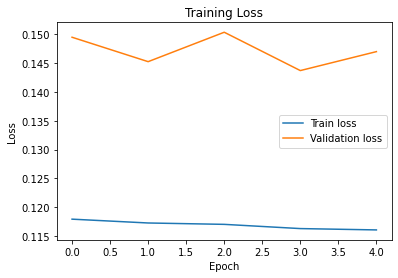

+ Train	 epoch: 6/20	 batch: 500/5366	 loss: 0.10621316730976105
+ Train	 epoch: 6/20	 batch: 1000/5366	 loss: 0.11350107192993164
+ Train	 epoch: 6/20	 batch: 1500/5366	 loss: 0.10703761875629425
+ Train	 epoch: 6/20	 batch: 2000/5366	 loss: 0.13436202704906464
+ Train	 epoch: 6/20	 batch: 2500/5366	 loss: 0.1048964262008667
+ Train	 epoch: 6/20	 batch: 3000/5366	 loss: 0.12815754115581512
+ Train	 epoch: 6/20	 batch: 3500/5366	 loss: 0.09949720650911331
+ Train	 epoch: 6/20	 batch: 4000/5366	 loss: 0.107593834400177
+ Train	 epoch: 6/20	 batch: 4500/5366	 loss: 0.13173460960388184
+ Train	 epoch: 6/20	 batch: 5000/5366	 loss: 0.0971359834074974
Train	 epoch: 6/20	 loss: 0.11557052995102911
Validation	 epoch: 6/20	 loss: 0.1412622332572937
Saving model


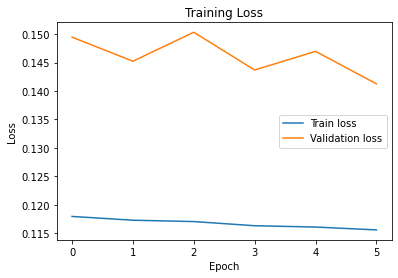

+ Train	 epoch: 7/20	 batch: 500/5366	 loss: 0.1196170374751091
+ Train	 epoch: 7/20	 batch: 1000/5366	 loss: 0.11470949649810791
+ Train	 epoch: 7/20	 batch: 1500/5366	 loss: 0.132175013422966
+ Train	 epoch: 7/20	 batch: 2000/5366	 loss: 0.12443599104881287
+ Train	 epoch: 7/20	 batch: 2500/5366	 loss: 0.09708676487207413
+ Train	 epoch: 7/20	 batch: 3000/5366	 loss: 0.12999555468559265
+ Train	 epoch: 7/20	 batch: 3500/5366	 loss: 0.10983070731163025
+ Train	 epoch: 7/20	 batch: 4000/5366	 loss: 0.11622436344623566
+ Train	 epoch: 7/20	 batch: 4500/5366	 loss: 0.1007867306470871
+ Train	 epoch: 7/20	 batch: 5000/5366	 loss: 0.12392141669988632
Train	 epoch: 7/20	 loss: 0.11515069563404154
Validation	 epoch: 7/20	 loss: 0.14677761867642403
Saving model


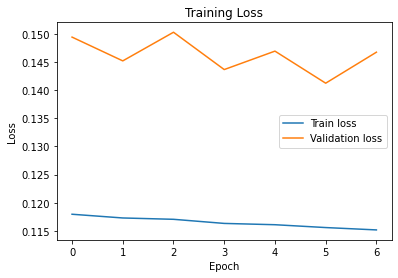

+ Train	 epoch: 8/20	 batch: 500/5366	 loss: 0.13403376936912537
+ Train	 epoch: 8/20	 batch: 1000/5366	 loss: 0.12990683317184448
+ Train	 epoch: 8/20	 batch: 1500/5366	 loss: 0.1069820374250412
+ Train	 epoch: 8/20	 batch: 2000/5366	 loss: 0.12884734570980072
+ Train	 epoch: 8/20	 batch: 2500/5366	 loss: 0.11230603605508804
+ Train	 epoch: 8/20	 batch: 3000/5366	 loss: 0.10738702118396759
+ Train	 epoch: 8/20	 batch: 3500/5366	 loss: 0.1212376058101654
+ Train	 epoch: 8/20	 batch: 4000/5366	 loss: 0.14145061373710632
+ Train	 epoch: 8/20	 batch: 4500/5366	 loss: 0.11658072471618652
+ Train	 epoch: 8/20	 batch: 5000/5366	 loss: 0.10141575336456299
Train	 epoch: 8/20	 loss: 0.11472705757489099
Validation	 epoch: 8/20	 loss: 0.14360637962818146
Saving model


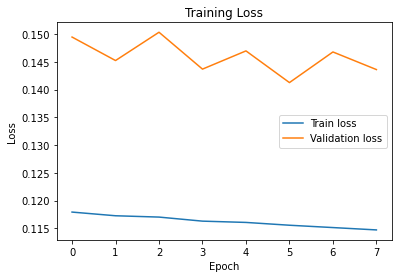

+ Train	 epoch: 9/20	 batch: 500/5366	 loss: 0.10061372071504593
+ Train	 epoch: 9/20	 batch: 1000/5366	 loss: 0.1166621595621109
+ Train	 epoch: 9/20	 batch: 1500/5366	 loss: 0.12356749922037125
+ Train	 epoch: 9/20	 batch: 2000/5366	 loss: 0.12412665784358978
+ Train	 epoch: 9/20	 batch: 2500/5366	 loss: 0.09228675812482834
+ Train	 epoch: 9/20	 batch: 3000/5366	 loss: 0.1142171174287796
+ Train	 epoch: 9/20	 batch: 3500/5366	 loss: 0.09445607662200928
+ Train	 epoch: 9/20	 batch: 4000/5366	 loss: 0.11382488161325455
+ Train	 epoch: 9/20	 batch: 4500/5366	 loss: 0.1092691496014595
+ Train	 epoch: 9/20	 batch: 5000/5366	 loss: 0.14272211492061615
Train	 epoch: 9/20	 loss: 0.11416839683817875
Validation	 epoch: 9/20	 loss: 0.15027597174048424
Saving model


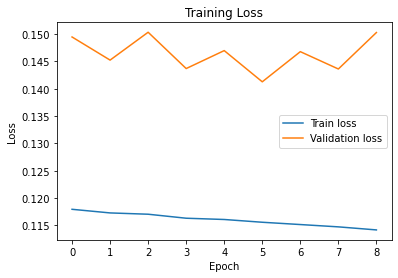

+ Train	 epoch: 10/20	 batch: 500/5366	 loss: 0.11932303756475449
+ Train	 epoch: 10/20	 batch: 1000/5366	 loss: 0.12503737211227417
+ Train	 epoch: 10/20	 batch: 1500/5366	 loss: 0.11363059282302856
+ Train	 epoch: 10/20	 batch: 2000/5366	 loss: 0.09426926076412201
+ Train	 epoch: 10/20	 batch: 2500/5366	 loss: 0.11795775592327118
+ Train	 epoch: 10/20	 batch: 3000/5366	 loss: 0.12029071152210236
+ Train	 epoch: 10/20	 batch: 3500/5366	 loss: 0.10077663511037827
+ Train	 epoch: 10/20	 batch: 4000/5366	 loss: 0.12083608657121658
+ Train	 epoch: 10/20	 batch: 4500/5366	 loss: 0.1257721483707428
+ Train	 epoch: 10/20	 batch: 5000/5366	 loss: 0.11934886872768402
Train	 epoch: 10/20	 loss: 0.11396862347507894
Validation	 epoch: 10/20	 loss: 0.14118166640400887
Saving model


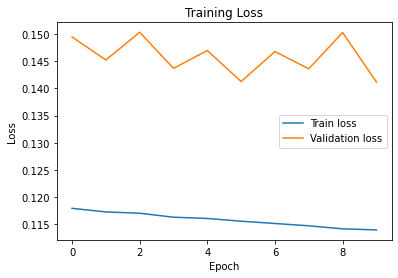

+ Train	 epoch: 11/20	 batch: 500/5366	 loss: 0.08938538283109665
+ Train	 epoch: 11/20	 batch: 1000/5366	 loss: 0.0977352112531662
+ Train	 epoch: 11/20	 batch: 1500/5366	 loss: 0.114596426486969
+ Train	 epoch: 11/20	 batch: 2000/5366	 loss: 0.11312796175479889
+ Train	 epoch: 11/20	 batch: 2500/5366	 loss: 0.11663137376308441
+ Train	 epoch: 11/20	 batch: 3000/5366	 loss: 0.092176154255867
+ Train	 epoch: 11/20	 batch: 3500/5366	 loss: 0.16468411684036255
+ Train	 epoch: 11/20	 batch: 4000/5366	 loss: 0.12162958085536957
+ Train	 epoch: 11/20	 batch: 4500/5366	 loss: 0.09088736772537231
+ Train	 epoch: 11/20	 batch: 5000/5366	 loss: 0.0918295755982399
Train	 epoch: 11/20	 loss: 0.11364895594800936
Validation	 epoch: 11/20	 loss: 0.1440592296421528
Saving model


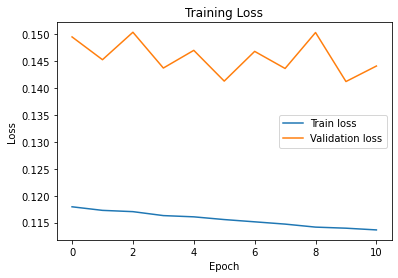

+ Train	 epoch: 12/20	 batch: 500/5366	 loss: 0.11323176324367523
+ Train	 epoch: 12/20	 batch: 1000/5366	 loss: 0.105521559715271
+ Train	 epoch: 12/20	 batch: 1500/5366	 loss: 0.12707017362117767
+ Train	 epoch: 12/20	 batch: 2000/5366	 loss: 0.11569157242774963
+ Train	 epoch: 12/20	 batch: 2500/5366	 loss: 0.09932530671358109
+ Train	 epoch: 12/20	 batch: 3000/5366	 loss: 0.11212614923715591
+ Train	 epoch: 12/20	 batch: 3500/5366	 loss: 0.1273810714483261
+ Train	 epoch: 12/20	 batch: 4000/5366	 loss: 0.13401320576667786
+ Train	 epoch: 12/20	 batch: 4500/5366	 loss: 0.11419923603534698
+ Train	 epoch: 12/20	 batch: 5000/5366	 loss: 0.1128290593624115
Train	 epoch: 12/20	 loss: 0.11331090865364458
Validation	 epoch: 12/20	 loss: 0.14617667347192764
Saving model


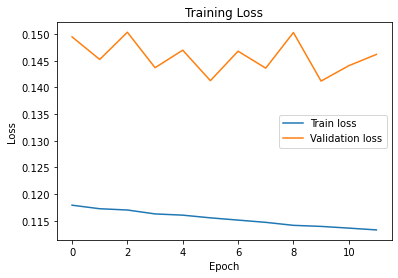

+ Train	 epoch: 13/20	 batch: 500/5366	 loss: 0.1097598522901535
+ Train	 epoch: 13/20	 batch: 1000/5366	 loss: 0.10661056637763977
+ Train	 epoch: 13/20	 batch: 1500/5366	 loss: 0.12836897373199463
+ Train	 epoch: 13/20	 batch: 2000/5366	 loss: 0.10357537865638733
+ Train	 epoch: 13/20	 batch: 2500/5366	 loss: 0.11092177033424377
+ Train	 epoch: 13/20	 batch: 3000/5366	 loss: 0.12550538778305054
+ Train	 epoch: 13/20	 batch: 3500/5366	 loss: 0.11783914268016815
+ Train	 epoch: 13/20	 batch: 4000/5366	 loss: 0.11466343700885773
+ Train	 epoch: 13/20	 batch: 4500/5366	 loss: 0.11089926958084106
+ Train	 epoch: 13/20	 batch: 5000/5366	 loss: 0.12407132238149643
Train	 epoch: 13/20	 loss: 0.11281203833886638
Validation	 epoch: 13/20	 loss: 0.14091472327709198
Saving model


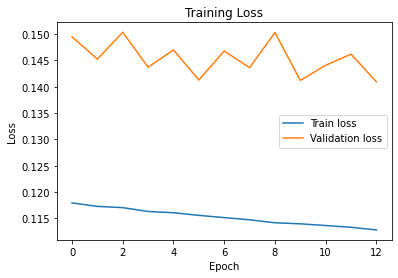

+ Train	 epoch: 14/20	 batch: 500/5366	 loss: 0.12712903320789337
+ Train	 epoch: 14/20	 batch: 1000/5366	 loss: 0.10271449387073517
+ Train	 epoch: 14/20	 batch: 1500/5366	 loss: 0.11206711828708649
+ Train	 epoch: 14/20	 batch: 2000/5366	 loss: 0.13226942718029022
+ Train	 epoch: 14/20	 batch: 2500/5366	 loss: 0.12079405784606934
+ Train	 epoch: 14/20	 batch: 3000/5366	 loss: 0.10036227852106094
+ Train	 epoch: 14/20	 batch: 3500/5366	 loss: 0.11613596230745316
+ Train	 epoch: 14/20	 batch: 4000/5366	 loss: 0.12260252237319946
+ Train	 epoch: 14/20	 batch: 4500/5366	 loss: 0.1101360023021698
+ Train	 epoch: 14/20	 batch: 5000/5366	 loss: 0.10277144610881805
Train	 epoch: 14/20	 loss: 0.11277635966608474
Validation	 epoch: 14/20	 loss: 0.14454902708530426
Saving model


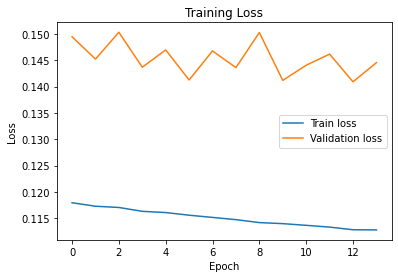

+ Train	 epoch: 15/20	 batch: 500/5366	 loss: 0.10288113355636597
+ Train	 epoch: 15/20	 batch: 1000/5366	 loss: 0.1167602688074112
+ Train	 epoch: 15/20	 batch: 1500/5366	 loss: 0.11756335198879242
+ Train	 epoch: 15/20	 batch: 2000/5366	 loss: 0.10220783948898315
+ Train	 epoch: 15/20	 batch: 2500/5366	 loss: 0.12218505144119263
+ Train	 epoch: 15/20	 batch: 3000/5366	 loss: 0.09481771290302277
+ Train	 epoch: 15/20	 batch: 3500/5366	 loss: 0.1203639805316925
+ Train	 epoch: 15/20	 batch: 4000/5366	 loss: 0.12871313095092773
+ Train	 epoch: 15/20	 batch: 4500/5366	 loss: 0.0914754569530487
+ Train	 epoch: 15/20	 batch: 5000/5366	 loss: 0.12031083554029465
Train	 epoch: 15/20	 loss: 0.11230791830140133
Validation	 epoch: 15/20	 loss: 0.14808205142617226
Saving model


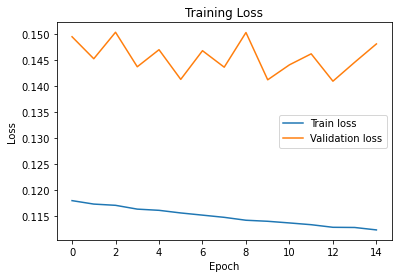

+ Train	 epoch: 16/20	 batch: 500/5366	 loss: 0.10901220142841339
+ Train	 epoch: 16/20	 batch: 1000/5366	 loss: 0.09813626110553741
+ Train	 epoch: 16/20	 batch: 1500/5366	 loss: 0.132106214761734
+ Train	 epoch: 16/20	 batch: 2000/5366	 loss: 0.10929081588983536
+ Train	 epoch: 16/20	 batch: 2500/5366	 loss: 0.11497554183006287
+ Train	 epoch: 16/20	 batch: 3000/5366	 loss: 0.10994890332221985
+ Train	 epoch: 16/20	 batch: 3500/5366	 loss: 0.11985063552856445
+ Train	 epoch: 16/20	 batch: 4000/5366	 loss: 0.1073470413684845
+ Train	 epoch: 16/20	 batch: 4500/5366	 loss: 0.11335471272468567
+ Train	 epoch: 16/20	 batch: 5000/5366	 loss: 0.11253303289413452
Train	 epoch: 16/20	 loss: 0.1120740349112586
Validation	 epoch: 16/20	 loss: 0.14024672470986843
Saving model


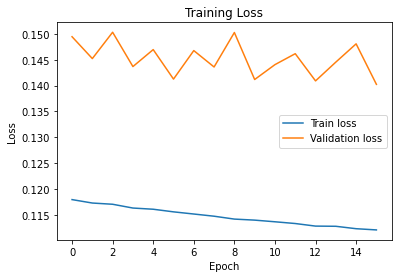

+ Train	 epoch: 17/20	 batch: 500/5366	 loss: 0.11105106770992279
+ Train	 epoch: 17/20	 batch: 1000/5366	 loss: 0.11801744997501373
+ Train	 epoch: 17/20	 batch: 1500/5366	 loss: 0.11417961865663528
+ Train	 epoch: 17/20	 batch: 2000/5366	 loss: 0.1039375513792038
+ Train	 epoch: 17/20	 batch: 2500/5366	 loss: 0.11830145120620728
+ Train	 epoch: 17/20	 batch: 3000/5366	 loss: 0.09770163893699646
+ Train	 epoch: 17/20	 batch: 3500/5366	 loss: 0.10211954265832901
+ Train	 epoch: 17/20	 batch: 4000/5366	 loss: 0.09616954624652863
+ Train	 epoch: 17/20	 batch: 4500/5366	 loss: 0.1119585633277893
+ Train	 epoch: 17/20	 batch: 5000/5366	 loss: 0.106660395860672
Train	 epoch: 17/20	 loss: 0.11177139191364469
Validation	 epoch: 17/20	 loss: 0.14498470723628998
Saving model


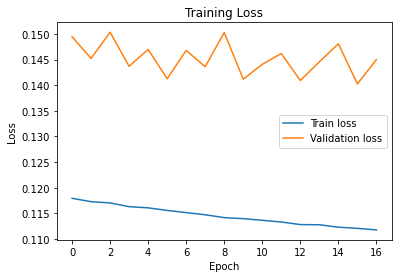

+ Train	 epoch: 18/20	 batch: 500/5366	 loss: 0.09979113936424255
+ Train	 epoch: 18/20	 batch: 1000/5366	 loss: 0.1331423670053482
+ Train	 epoch: 18/20	 batch: 1500/5366	 loss: 0.10373479127883911
+ Train	 epoch: 18/20	 batch: 2000/5366	 loss: 0.10915546864271164
+ Train	 epoch: 18/20	 batch: 2500/5366	 loss: 0.12226448953151703
+ Train	 epoch: 18/20	 batch: 3000/5366	 loss: 0.1005501076579094
+ Train	 epoch: 18/20	 batch: 3500/5366	 loss: 0.12228983640670776
+ Train	 epoch: 18/20	 batch: 4000/5366	 loss: 0.11395163089036942
+ Train	 epoch: 18/20	 batch: 4500/5366	 loss: 0.11333885788917542
+ Train	 epoch: 18/20	 batch: 5000/5366	 loss: 0.12201330065727234
Train	 epoch: 18/20	 loss: 0.1113867806801812
Validation	 epoch: 18/20	 loss: 0.1448396034538746
Saving model


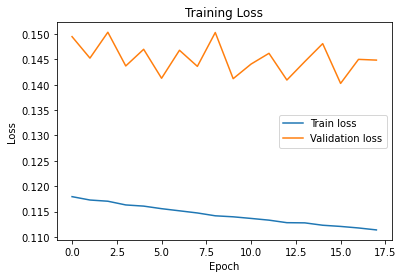

+ Train	 epoch: 19/20	 batch: 500/5366	 loss: 0.11801372468471527
+ Train	 epoch: 19/20	 batch: 1000/5366	 loss: 0.11206884682178497
+ Train	 epoch: 19/20	 batch: 1500/5366	 loss: 0.10150974243879318
+ Train	 epoch: 19/20	 batch: 2000/5366	 loss: 0.10121122002601624
+ Train	 epoch: 19/20	 batch: 2500/5366	 loss: 0.10237859189510345
+ Train	 epoch: 19/20	 batch: 3000/5366	 loss: 0.1307036429643631
+ Train	 epoch: 19/20	 batch: 3500/5366	 loss: 0.11779452115297318
+ Train	 epoch: 19/20	 batch: 4000/5366	 loss: 0.1271812468767166
+ Train	 epoch: 19/20	 batch: 4500/5366	 loss: 0.14124804735183716
+ Train	 epoch: 19/20	 batch: 5000/5366	 loss: 0.10358160734176636
Train	 epoch: 19/20	 loss: 0.11120647403327912
Validation	 epoch: 19/20	 loss: 0.13810206577181816
Saving model


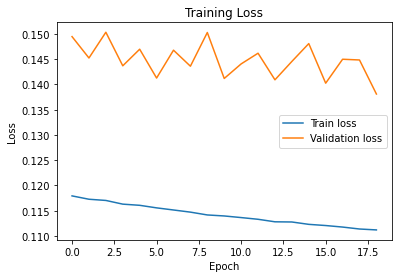

+ Train	 epoch: 20/20	 batch: 500/5366	 loss: 0.10192742943763733
+ Train	 epoch: 20/20	 batch: 1000/5366	 loss: 0.12439389526844025
+ Train	 epoch: 20/20	 batch: 1500/5366	 loss: 0.10764066874980927
+ Train	 epoch: 20/20	 batch: 2000/5366	 loss: 0.0921218991279602
+ Train	 epoch: 20/20	 batch: 2500/5366	 loss: 0.11523814499378204
+ Train	 epoch: 20/20	 batch: 3000/5366	 loss: 0.12102606892585754
+ Train	 epoch: 20/20	 batch: 3500/5366	 loss: 0.10194309055805206
+ Train	 epoch: 20/20	 batch: 4000/5366	 loss: 0.13448116183280945
+ Train	 epoch: 20/20	 batch: 4500/5366	 loss: 0.1165836825966835
+ Train	 epoch: 20/20	 batch: 5000/5366	 loss: 0.13019394874572754
Train	 epoch: 20/20	 loss: 0.11080580014225888
Validation	 epoch: 20/20	 loss: 0.14276240207254887
Saving model


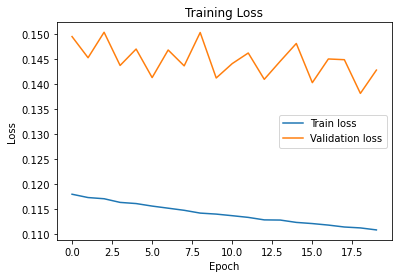

In [ ]:
if ph3_saved:
  savePath = savePath_base+"TTNet_Phase3_4.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph3_train_loss_log = checkpoint['train_loss_log']
  ph3_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 3 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"Phase2/TTNet_Phase2_29.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 3: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 3: All Stages ...')

for epoch in range(start_epoch+1, ph3_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
    
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

    # Model forward step
    with autocast():
      global_out, local_out, _, crop_params, event_out = model(window_batch)
    
    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (global+local+event) loss
    with autocast():
      global_loss_train = ball_loss(global_out,xy_downscale_batch) * global_weight
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = global_loss_train + local_loss_train + event_loss_train

    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph3_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")
    
    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainig losses
  print(f"Train\t epoch: {epoch}/{ph3_epochs}\t loss: {train_loss_total/batch_num}")
  ph3_train_loss_log.append(train_loss_total/batch_num)


  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step
      with autocast():
        global_out, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (global+local+event) loss
      with autocast():
        global_loss_train = ball_loss(global_out,xy_downscale_batch) * global_weight
        local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_train = event_loss(event_out,event_probs) * event_weight
        val_loss = global_loss_train + local_loss_train + event_loss_train
      
      loss = val_loss.detach().cpu().numpy()
      val_loss_total += loss

    ph3_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph3_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"TTNet_Phase3_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph3_train_loss_log,'val_loss_log':ph3_val_loss_log}
  torch.save(state, savePath) 
  ph3_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph3_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph3_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph3.png")
  plt.show()

## Testing

In [ ]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Final/TTNet_v2.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model']) 

<All keys matched successfully>

In [ ]:
transform = transforms.Compose([
  transforms.Resize((TTN_height,TTN_width)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class demo_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = sorted(glob.glob('./tmp/*.jpg'))
    self.window_paths = []

    for frame_no, _ in enumerate(self.img_paths):
      if not (window_size-2 < frame_no <= len(self.img_paths)-1):
        continue

      # Get frame window image paths
      window_path = []
      middle_index = frame_no-self.window_size+(self.window_size+1)//2
      for window_frame in range(self.window_size):
        window_path.append(self.img_paths[(frame_no+1)-self.window_size+window_frame])
      self.window_paths.append(window_path)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)

    return window_imgs, window_path[self.window_size//2]

  def __len__(self):
    return len(self.window_paths)

# Extracts all the frames from a video and saves them
def preprocess(video_path):
  cap = cv.VideoCapture(video_path)
  ret, frame = cap.read()
  count=0
  while(ret):
    cv.imwrite(f"tmp/{count:04d}.jpg", frame)
    ret, frame = cap.read()
    count += 1
    if count %200 == 0:
      print(f"Frame {count}")
  cap.release

# Predicts the ball location and events for a new video
def predict(video_path, preprocessing=True):
  if preprocessing:
    print("Preprocessing")
    preprocess(video_path)
  print("Loading demo dataset")
  demo_dataset  = demo_data_loader()
  demo_loader = DataLoader(demo_dataset, batch_size=16,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)

  cap = cv.VideoCapture(video_path)
  fps = cap.get(cv.CAP_PROP_FPS)
  cap.release
  fourcc = cv.VideoWriter_fourcc(*'mp4v')
  out = cv.VideoWriter('./Results/TTNet_Results/videos/out.mp4', fourcc, fps, (1920,1080))

  print("Making Predictions")
  model.eval()
  with torch.no_grad():
    events = ["Out of image", "Flying", "Bounce", "Hit", "Net Contact"]

    for i,data_batch in enumerate(tqdm(demo_loader)):
      # Read in demo batch
      window_imgs, window_centre = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
      # Model forward step
      global_out, local_out, local_in, crop_params, event_out = model(window_batch)

      local_out_clone = local_out.clone().detach()
      global_out_clone = global_out.clone().detach()
      event_out_clone = event_out.clone().detach()

      for out_index in range(local_out_clone.shape[0]):
        # Global bounding box
        _, x_min, y_min, x_max, y_max, _, _ = crop_params[out_index]

        # Ball prediction
        local_x = torch.argmax(local_out_clone[out_index,:TTN_width]).item()
        local_y = torch.argmax(local_out_clone[out_index,TTN_width:]).item()
        global_x = torch.argmax(global_out_clone[out_index,:TTN_width]).item()
        global_y = torch.argmax(global_out_clone[out_index,TTN_width:]).item()

        x_pred = global_x*data_width/TTN_width-TTN_width/2+local_x
        y_pred = global_y*data_height/TTN_height-TTN_height/2+local_y
        x_pred = 0 if x_pred<0 else int(x_pred)
        y_pred = 0 if y_pred<0 else int(y_pred)

        # Event prediction
        event_preds = event_out_clone[out_index]

        # Label frame
        centre_img = cv.imread(window_centre[out_index])
        cv.rectangle(centre_img, (x_min,y_min), (x_max,y_max), (0,0,255), 2)
        cv.circle(centre_img,(x_pred,y_pred), 8,  (0, 0, 255), 2)
        #cv.putText(centre_img, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
        event_text = f"Event: Not in image {event_preds[0].item():.2f}"
        cv.putText(centre_img, event_text, (50, 100), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)
        event_text = f"Event: Flying {event_preds[1].item():.2f}"
        cv.putText(centre_img, event_text, (50, 150), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        event_text = f"Event: Bouncing {event_preds[2].item():.2f}"
        cv.putText(centre_img, event_text, (50, 200), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        event_text = f"Event: Hit {event_preds[3].item():.2f}"
        cv.putText(centre_img, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)
        event_text = f"Event: Net Contact {event_preds[4].item():.2f}"
        cv.putText(centre_img, event_text, (50, 300), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

        out.write(centre_img)\
  out.release()

# Set preprocessing to True the first time you predict a video
predict("./Results/TTNet_Results/videos/test3.mp4", preprocessing=True)
#predict("./Dataset/videos/04.mp4", preprocessing=True)

Preprocessing
Frame 200
Frame 400
Frame 600
Frame 800
Frame 1000
Frame 1200
Frame 1400
Frame 1600
Loading demo dataset
Making Predictions


  0%|          | 0/111 [00:00<?, ?it/s]